## 合并 loop
得到    
/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix.txt # 行是loop（连接） 列是样本，值是 probability 
/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrixlog.txt  
/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog.txt #筛选出现次数大于30的差异loop  
/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.txt # 分列的次数大于30的loop       
/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_half_CGC.txt   
从 processed_matrix_half.txt 和 processed_matrix_halflog_pos_oncogene_2col.txt 合并

In [ ]:
import os


# 从 before_heatmap.sh 中获得的mtrix.txt，是共有的loop。用这个 name 合并所有的 loop，得到 processed_matrix.txt
# 文件所在目录的路径
directory = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff'

# 读取matrix.txt文件，获取模式
with open(os.path.join(directory, 'mtrix.txt'), 'r') as file:
    matrix_lines = file.readlines()

# 第一行是列名，我们忽略它，从第二行开始读取模式
pattern_to_index = {}
for line in matrix_lines[1:]:  # 可能需要调整索引以匹配您的文件格式
    parts = line.strip().split()
    pattern = parts[0]  # 假设模式是每行的第一个值
    pattern_to_index[pattern] = len(pattern_to_index)

# 初始化matrix_data字典，用于存储每个模式和每个文件的匹配情况
# 初始时，每个模式的每个文件对应位置的值为1
matrix_data = {pattern: {'0.051': []} for pattern in pattern_to_index}

# 获取所有vsNPC.loop1文件的列名（文件名除去vsNPC.loop1部分）
column_names = {filename[:-11] for filename in os.listdir(directory) if filename.endswith('vsNPC.loop1')}

# 读取每个vsNPC.loop1文件，并更新matrix_data
for filename in os.listdir(directory):
    if filename.endswith('vsNPC.loop1'):
        column_name = filename[:-11]  # 去除vsNPC.loop1得到列名
        with open(os.path.join(directory, filename), 'r') as file:
            for line in file:
                parts = line.strip().split()
                pattern_in_file = parts[-1]  # 模式在最后一列
                if pattern_in_file in pattern_to_index:
                    index = pattern_to_index[pattern_in_file]
                    # 更新第7列的值
                    matrix_data[pattern_in_file][column_name] = [parts[6]]  # 假设第7列的索引是6

# 准备写入处理后的数据到新的matrix.txt文件
with open(os.path.join(directory, 'processed_matrix.txt'), 'w') as file:
    file.write('Differential loops ( = 673)')  # 写入标题行
    for column_name in sorted(column_names):
        file.write('\t' + column_name)
    file.write('\n')
    
    # 写入每个模式的数据
    for pattern, columns in matrix_data.items():
        file.write(pattern)
        for column_name in sorted(column_names):
            if column_name in columns:
                file.write('\t' + columns[column_name][0])  # 取第7列的值
            else:
                file.write('\t0.051')  # 如果没有匹配的值，写入1
        file.write('\n')

print('Processed data has been written to processed_matrix.txt')

Processed data has been written to processed_matrix.txt


In [151]:
import pandas as pd
import numpy as np

# 读取文件，跳过首行和首列
data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix.txt', sep='\t')
data1 = data.iloc[:, 1:]  # 跳过首行和首列

# 对剩余的值取 -log10
data_plus_one = data1 + 1
data_transformed = -np.log10(data_plus_one)
result = pd.concat([data.iloc[:, 0], data_transformed], axis=1)

#print(result.iloc[:, 0])
# 显示转换后的DataFrame
result.to_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrixlog.txt', sep='\t', index=False)


0         chr10_100295000_100300000_chr10_100500000_1005...
1         chr10_100295000_100300000_chr10_100510000_1005...
2         chr10_100300000_100305000_chr10_100425000_1004...
3         chr10_100300000_100305000_chr10_100430000_1004...
4         chr10_100300000_100305000_chr10_100435000_1004...
                                ...                        
166912            chrX_9895000_9900000_chrX_9935000_9940000
166913          chrX_9985000_9990000_chrX_10115000_10120000
166914         chrX_9995000_10000000_chrX_10110000_10115000
166915         chrX_9995000_10000000_chrX_10115000_10120000
166916         chrX_9995000_10000000_chrX_10120000_10125000
Name: Differential loops ( = 673), Length: 166917, dtype: object


In [ ]:
# 筛选出现次数大于一半的行
# 提取原始文件中值为-0.02160271602824219的行，如果该行中-0.02160271602824219的数量小于30，则写入新文件

original_file_path = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrixlog.txt'
new_file_path = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog.txt'

with open(original_file_path, 'r') as original_file, \
     open(new_file_path, 'w') as new_file:
    # 逐行读取原始文件
    for line in original_file:
        # 分割行中的值
        values = line.split()
        
        # 计算1的数量
        count_ones = sum(1 for value in values if value == '-0.02160271602824219')
        
        # 如果1的数量小于30，则写入新文件
        if count_ones < 30:
            new_file.write(line)

In [224]:
###分列
import pandas as pd

# 定义输入文件路径
input_file = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog.txt'
output_file = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.txt'
# 读取文件，假设列是用制表符分隔的
data = pd.read_csv(input_file, sep='\t')
split_columns = data["Differential loops ( = 673)"].str.split('_', expand=True)
# 给新分隔的列命名
new_column_names = ['chr1', 'stt1', 'end1', 'chr2', 'stt2', 'end2']
split_columns.columns = new_column_names

# 将原始数据与新分隔的列合并，但不包括原始的"Differential loops ( = 673)"列
result = pd.concat([split_columns, data.drop("Differential loops ( = 673)", axis=1)], axis=1)
result.to_csv(output_file, sep='\t', index=False)

print("文件处理完成，结果已保存到:", output_file)

文件处理完成，结果已保存到: /cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.txt


**/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.txt 用 before_heatmap.sh 处理**

输出    
/cluster/home/futing/Project/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos_oncogene.txt    
/cluster/home/futing/Project/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos_gene.bedpe      
/cluster/home/futing/Project/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.bedpe   
/cluster/home/futing/Project/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos.txt

In [284]:
import pandas as pd

# 读取两个文件
file_path_half = "/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_half.txt"
file_path_oncogene = "/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos_oncogene_2col.txt"

# 假设文件中的数据是由制表符分隔的，且没有列标题
data_half = pd.read_csv(file_path_half, sep="\t", header=None)
data_oncogene = pd.read_csv(file_path_oncogene, sep="\t", header=None)

# 创建一个字典，将oncogene文件的第一列和第二列对应起来
oncogene_dict = dict(zip(data_oncogene[0], data_oncogene[1]))

# 为data_half添加新列CGC，初始值为None
data_half['CGC'] = 'other'

# 遍历data_half的第一列，如果值在oncogene_dict中，则赋值对应的CGC值
for index, row in data_half.iterrows():
    if row[0] in oncogene_dict:
        data_half.at[index, 'CGC'] = oncogene_dict[row[0]]

# 将修改后的数据保存到新文件
new_file_path = "/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_half_CGC.txt"
data_half.to_csv(new_file_path, sep="\t", index=False, header=False)


## 绘图

/cluster/home/jialu/miniconda3/envs/cooltools/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/cluster/home/jialu/miniconda3/envs/cooltools/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


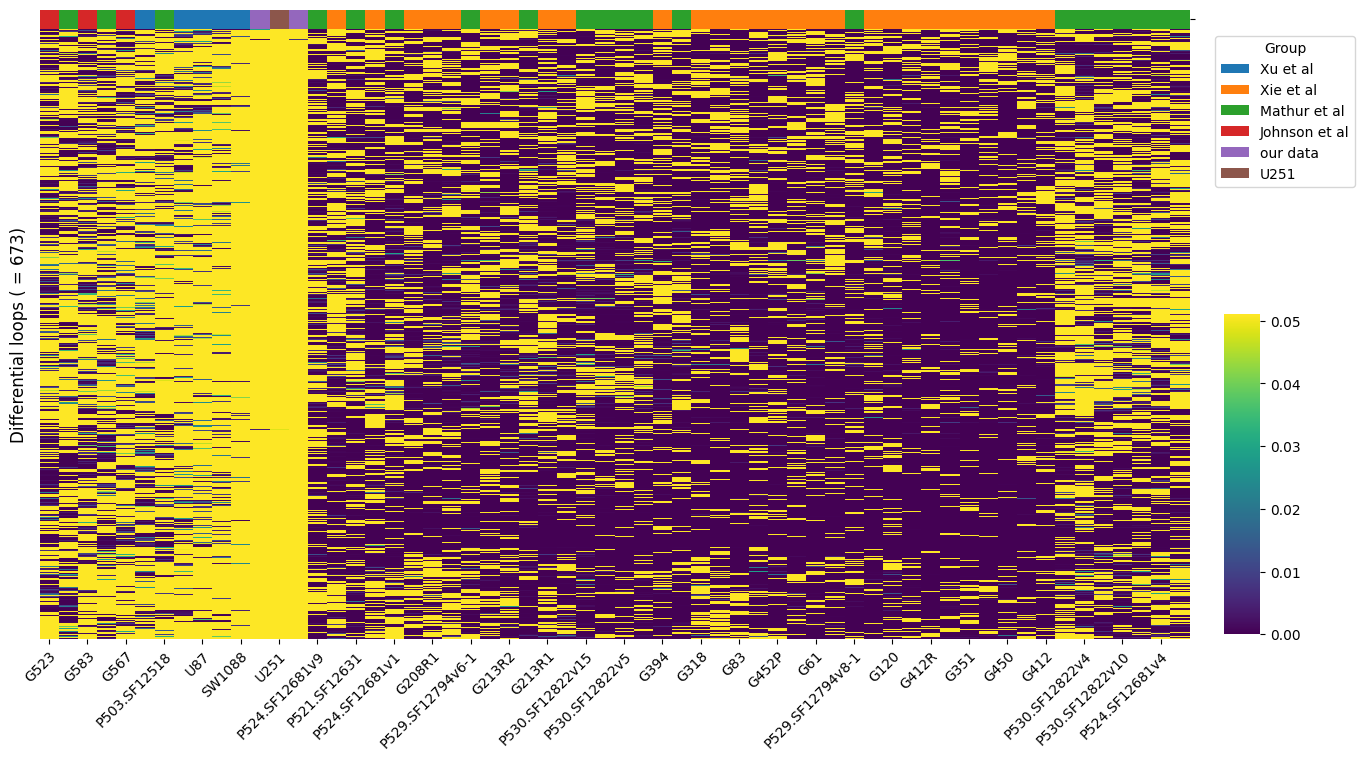

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Your existing code
column_order = [
    "G1", "G120", "G148", "G163", "G171", "G181", "G208R1", "G208R2",
    "G213R1", "G213R2", "G275", "G275R", "G28", "G318", "G323", "G351",
    "G390", "G394", "G402", "G412", "G412R", "G450", "G452P", "G457", "G23",
    "G61", "G62", "G83", "P455.SF11901", "P475.SF12180",
    "P498.SF12251", "P503.SF12518", "P519.SF12601", "P521.SF12631",
    "P524.SF12681v1", "P524.SF12681v4", "P524.SF12681v9",
    "P529.SF12794v1-1", "P529.SF12794v6-1", "P529.SF12794v8-1",
    "P530.SF12822v10", "P530.SF12822v13", "P530.SF12822v14",
    "P530.SF12822v15", "P530.SF12822v18", "P530.SF12822v19",
    "P530.SF12822v2", "P530.SF12822v4", "P530.SF12822v5", "G523", "G567", "G583",  "A172", "SW1088",
    "U118", "U343", "U87", "U251", "ts543", "ts667"
]

matrix_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_half.txt', sep='\t', index_col=0)
matrix_data1 = matrix_data[column_order]

# Load column grouping data
col_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/coldata', sep='\t', index_col=0)
# Create a dictionary mapping column names to their respective h
col_group_mapping = dict(zip(col_data.index, col_data.iloc[:, 0]))
group_colors = {group: f'C{i}' for i, group in enumerate(col_data.iloc[:, 0].unique())}
col_group_colors = pd.Series([group_colors[grp] for grp in matrix_data1.columns.map(col_group_mapping)], index=matrix_data1.columns)

# Create the clustermap
g = sns.clustermap(matrix_data1, cmap='viridis', figsize=(12, 8), row_cluster=True, col_cluster=True, dendrogram_ratio=(0.0001, 0.0001), 
                   col_colors=col_group_colors, yticklabels=False, cbar_pos=(1, 0.2, 0.03, 0.4)) ###char_pos 水平距离、垂直距离、宽度、高度
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
g.ax_heatmap.set_ylabel("")

# Add a custom ylabel on the left side of the heatmap
g.ax_heatmap.text(-0.01, 0.5, "Differential loops ( = 673)", va='center', ha='right', 
                  rotation='vertical', transform=g.ax_heatmap.transAxes, 
                  color='black', fontsize=12)
# Create legend
handles = [Patch(facecolor=color, label=group) for group, color in group_colors.items()]
g.ax_heatmap.legend(handles=handles, title='Group', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()


/cluster/home/jialu/miniconda3/envs/cooltools/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/cluster/home/jialu/miniconda3/envs/cooltools/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


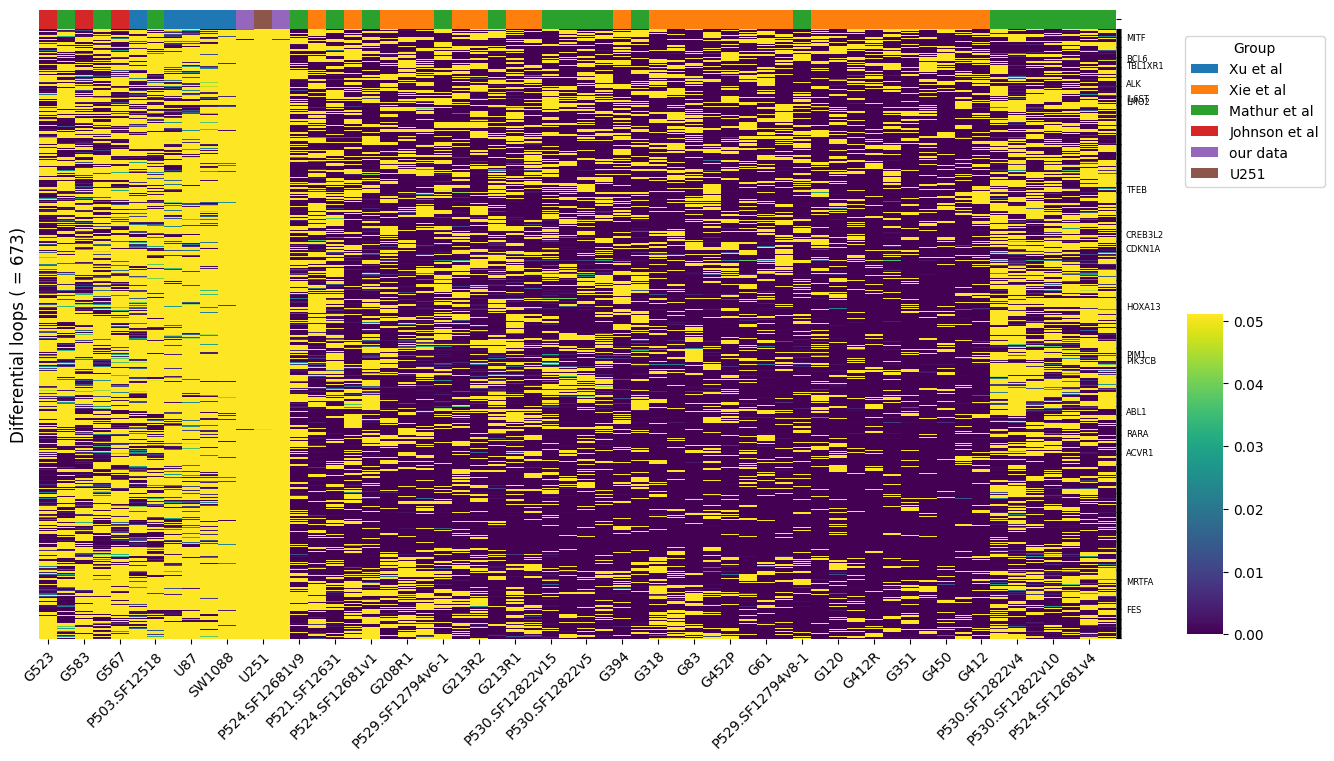

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Your existing code
column_order = [
    "G1", "G120", "G148", "G163", "G171", "G181", "G208R1", "G208R2",
    "G213R1", "G213R2", "G275", "G275R", "G28", "G318", "G323", "G351",
    "G390", "G394", "G402", "G412", "G412R", "G450", "G452P", "G457", "G23",
    "G61", "G62", "G83", "P455.SF11901", "P475.SF12180",
    "P498.SF12251", "P503.SF12518", "P519.SF12601", "P521.SF12631",
    "P524.SF12681v1", "P524.SF12681v4", "P524.SF12681v9",
    "P529.SF12794v1-1", "P529.SF12794v6-1", "P529.SF12794v8-1",
    "P530.SF12822v10", "P530.SF12822v13", "P530.SF12822v14",
    "P530.SF12822v15", "P530.SF12822v18", "P530.SF12822v19",
    "P530.SF12822v2", "P530.SF12822v4", "P530.SF12822v5", "G523", "G567", "G583",  "A172", "SW1088",
    "U118", "U343", "U87", "U251", "ts543", "ts667"
]

matrix_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_half_CGC.txt', sep='\t', index_col=0)
matrix_data1 = matrix_data[column_order]

# Load column grouping data
col_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/coldata', sep='\t', index_col=0)
# Create a dictionary mapping column names to their respective groups
col_group_mapping = dict(zip(col_data.index, col_data.iloc[:, 0]))
group_colors = {group: f'C{i}' for i, group in enumerate(col_data.iloc[:, 0].unique())}
col_group_colors = pd.Series([group_colors[grp] for grp in matrix_data1.columns.map(col_group_mapping)], index=matrix_data1.columns)

# !!! Check the last column values and create a list of yticklabels
last_column = matrix_data.columns[-1]
yticklabels = [label if matrix_data[last_column][i] != 'other' else '' for i, label in enumerate(matrix_data[last_column])]

# Create the clustermap
g = sns.clustermap(matrix_data1, cmap='viridis', figsize=(12, 8), row_cluster=True, col_cluster=True, dendrogram_ratio=(0.0001, 0.0001), 
                   col_colors=col_group_colors, yticklabels=yticklabels, cbar_pos=(0.97, 0.2, 0.03, 0.4))

plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6) 
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
g.ax_heatmap.set_ylabel("")

# Add a custom ylabel on the left side of the heatmap
g.ax_heatmap.text(-0.01, 0.5, "Differential loops ( = 673)", va='center', ha='right', 
                  rotation='vertical', transform=g.ax_heatmap.transAxes, 
                  color='black', fontsize=12)
# Create legend
handles = [Patch(facecolor=color, label=group) for group, color in group_colors.items()]
g.ax_heatmap.legend(handles=handles, title='Group', loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

60


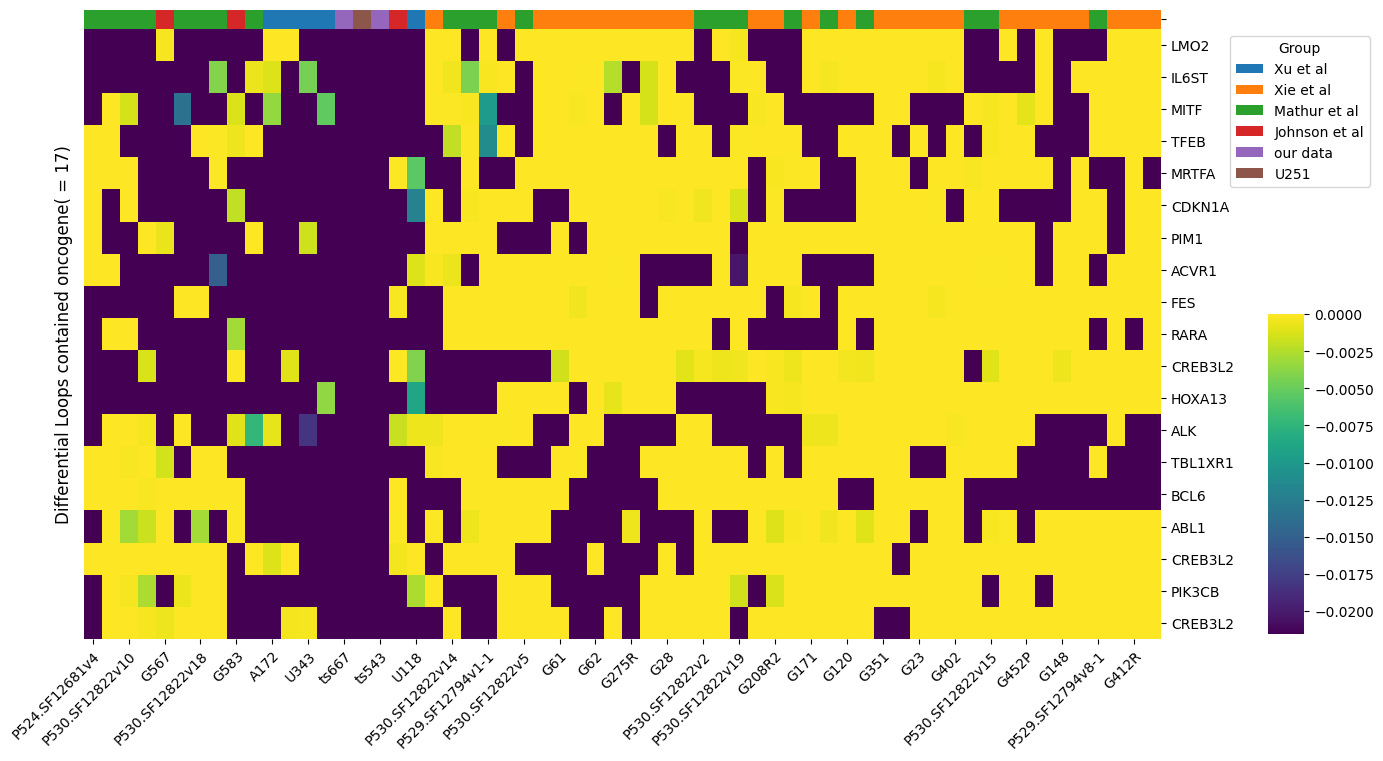

In [309]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Your existing code
column_order = [
    "G1", "G120", "G148", "G163", "G171", "G181", "G208R1", "G208R2",
    "G213R1", "G213R2", "G275", "G275R", "G28", "G318", "G323", "G351",
    "G390", "G394", "G402", "G412", "G412R", "G450", "G452P", "G457", "G23",
    "G61", "G62", "G83", "P455.SF11901", "P475.SF12180",
    "P498.SF12251", "P503.SF12518", "P519.SF12601", "P521.SF12631",
    "P524.SF12681v1", "P524.SF12681v4", "P524.SF12681v9",
    "P529.SF12794v1-1", "P529.SF12794v6-1", "P529.SF12794v8-1",
    "P530.SF12822v10", "P530.SF12822v13", "P530.SF12822v14",
    "P530.SF12822v15", "P530.SF12822v18", "P530.SF12822v19",
    "P530.SF12822v2", "P530.SF12822v4", "P530.SF12822v5", "G523", "G567", "G583",  "A172", "SW1088",
    "U118", "U343", "U87", "U251", "ts543", "ts667"
]

matrix_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/processed_matrix_halflog_pos_oncogene_draw.txt', sep='\t', index_col=0)
print(matrix_data.shape[1])
matrix_data = matrix_data[column_order]

# Load column grouping data
col_data = pd.read_csv('/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff/coldata', sep='\t', index_col=0)
# Create a dictionary mapping column names to their respective groups
col_group_mapping = dict(zip(col_data.index, col_data.iloc[:, 0]))
group_colors = {group: f'C{i}' for i, group in enumerate(col_data.iloc[:, 0].unique())}
col_group_colors = pd.Series([group_colors[grp] for grp in matrix_data.columns.map(col_group_mapping)], index=matrix_data.columns)

# Create the clustermap
g = sns.clustermap(matrix_data, cmap='viridis', figsize=(12, 8), row_cluster=True, col_cluster=True, dendrogram_ratio=(0.0001, 0.0001), 
                   col_colors=col_group_colors, yticklabels=True, cbar_pos=(1, 0.2, 0.03, 0.4)) ###char_pos 水平距离、垂直距离、宽度、高度
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
g.ax_heatmap.set_ylabel("")

# Add a custom ylabel on the left side of the heatmap
g.ax_heatmap.text(-0.01, 0.5, "Differential Loops contained oncogene( = 17)", va='center', ha='right', 
                  rotation='vertical', transform=g.ax_heatmap.transAxes, 
                  color='black', fontsize=12)
# Create legend
handles = [Patch(facecolor=color, label=group) for group, color in group_colors.items()]
g.ax_heatmap.legend(handles=handles, title='Group', loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()


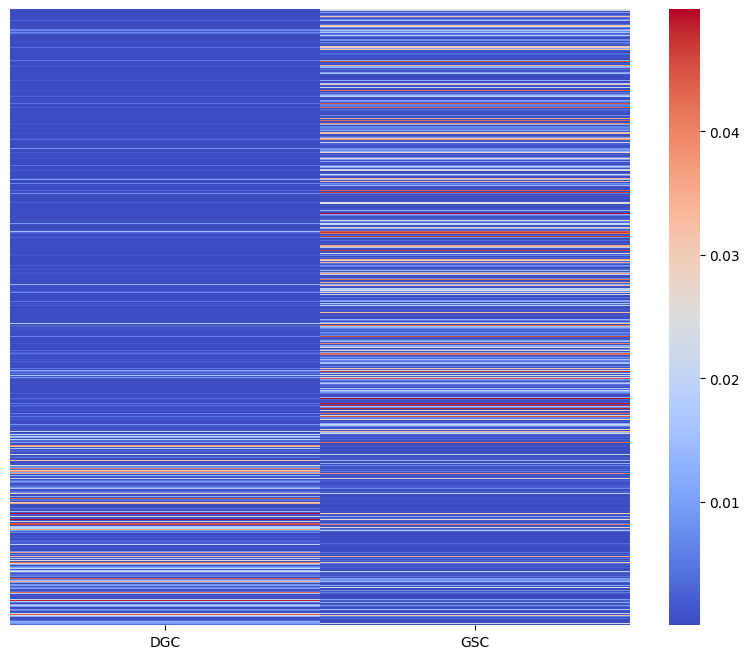

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 加载数据
data = pd.read_csv('heatmap.txt', sep='\t')

# 绘制热图，不显示数值，隐藏行名
plt.figure(figsize=(10, 8))  # 可以根据需要调整图形大小
sns.heatmap(data, annot=False, cmap='coolwarm', cbar=True, yticklabels=False)

# 显示图形
plt.show()

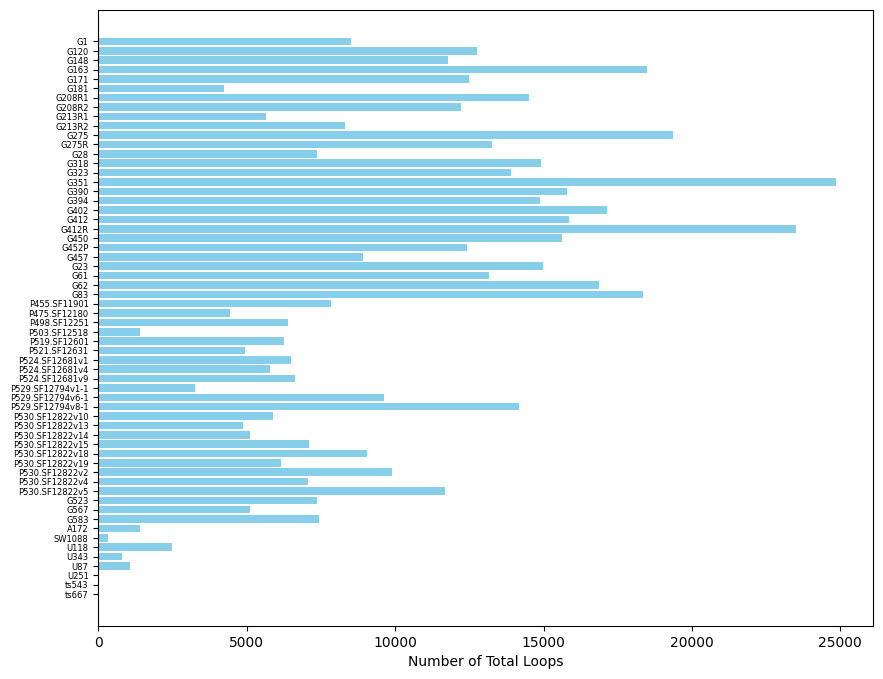

In [239]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re  # 导入正则表达式模块

# 设置当前目录
directory = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff'

# 遍历目录，找到所有的.bedpe文件
bedpe_files = [f for f in os.listdir(directory) if f.endswith('.loop1')]

# 初始化一个列表来存储处理后的文件名和行数
file_lines = []

# 定义列的顺序
column_order = [
    "G1", "G120", "G148", "G163", "G171", "G181", "G208R1", "G208R2",
    "G213R1", "G213R2", "G275", "G275R", "G28", "G318", "G323", "G351",
    "G390", "G394", "G402", "G412", "G412R", "G450", "G452P", "G457", "G23",
    "G61", "G62", "G83", "P455.SF11901", "P475.SF12180",
    "P498.SF12251", "P503.SF12518", "P519.SF12601", "P521.SF12631",
    "P524.SF12681v1", "P524.SF12681v4", "P524.SF12681v9",
    "P529.SF12794v1-1", "P529.SF12794v6-1", "P529.SF12794v8-1",
    "P530.SF12822v10", "P530.SF12822v13", "P530.SF12822v14",
    "P530.SF12822v15", "P530.SF12822v18", "P530.SF12822v19",
    "P530.SF12822v2", "P530.SF12822v4", "P530.SF12822v5", "G523", "G567", "G583",  "A172", "SW1088",
    "U118", "U343", "U87", "U251", "ts543", "ts667"
]

# 统计每个文件的行数，并处理文件名
for file in bedpe_files:
    # 使用正则表达式删除文件名中的_vsNPC.diffloop1
    clean_file_name = re.sub(r'(?:vsNPC\.loop1)', '', file)
    # 打开文件并统计行数
    file_path = os.path.join(directory, file)
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # 将处理后的文件名和行数添加到列表中
    file_lines.append((clean_file_name, len(lines)))

# 将数据转换为DataFrame
df_files = pd.DataFrame(file_lines, columns=['Cleaned File', 'Lines'])

# 检查是否有数据要绘制
if not df_files.empty:
    # 绘制柱状图
    plt.figure(figsize=(10, 8))
    # 按照column_order中的顺序绘制每个文件的行数
    for col in column_order:
        if col in df_files['Cleaned File'].values:
            idx = df_files['Cleaned File'].values.tolist().index(col)
            plt.barh(col, df_files.loc[idx, 'Lines'], color='skyblue')
    
    plt.xlabel('Number of Total Loops')
    plt.gca().invert_yaxis()  # 反转y轴，长的条在上
    plt.tick_params(axis='y', which='both', labelsize=6)  # 调整Y轴刻度标签的字体大小和旋转角度
    plt.show()
else:
    print("No data to plot, or all files have zero lines.")

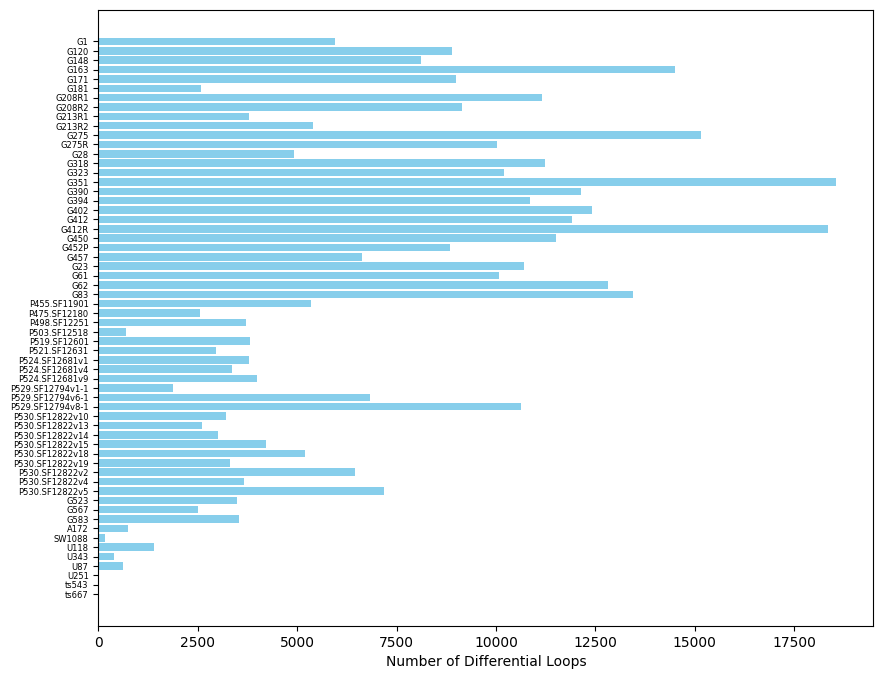

In [251]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re  # 导入正则表达式模块

# 设置当前目录
directory = '/cluster/home/tmp/GBM/HiC/10loop/mustache/diffloop_NPC/diff'

# 遍历目录，找到所有的.bedpe文件
bedpe_files = [f for f in os.listdir(directory) if f.endswith('vsNPC.diffloop1')]

# 初始化一个列表来存储处理后的文件名和行数
file_lines = []

# 定义列的顺序
column_order = [
    "G1", "G120", "G148", "G163", "G171", "G181", "G208R1", "G208R2",
    "G213R1", "G213R2", "G275", "G275R", "G28", "G318", "G323", "G351",
    "G390", "G394", "G402", "G412", "G412R", "G450", "G452P", "G457", "G23",
    "G61", "G62", "G83", "P455.SF11901", "P475.SF12180",
    "P498.SF12251", "P503.SF12518", "P519.SF12601", "P521.SF12631",
    "P524.SF12681v1", "P524.SF12681v4", "P524.SF12681v9",
    "P529.SF12794v1-1", "P529.SF12794v6-1", "P529.SF12794v8-1",
    "P530.SF12822v10", "P530.SF12822v13", "P530.SF12822v14",
    "P530.SF12822v15", "P530.SF12822v18", "P530.SF12822v19",
    "P530.SF12822v2", "P530.SF12822v4", "P530.SF12822v5", "G523", "G567", "G583",  "A172", "SW1088",
    "U118", "U343", "U87", "U251", "ts543", "ts667"
]

# 统计每个文件的行数，并处理文件名
for file in bedpe_files:
    # 使用正则表达式删除文件名中的_vsNPC.diffloop1
    clean_file_name = re.sub(r'(?:vsNPC\.diffloop1)', '', file)
    # 打开文件并统计行数
    file_path = os.path.join(directory, file)
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # 将处理后的文件名和行数添加到列表中
    file_lines.append((clean_file_name, len(lines)))

# 将数据转换为DataFrame
df_files = pd.DataFrame(file_lines, columns=['Cleaned File', 'Lines'])

# 检查是否有数据要绘制
if not df_files.empty:
    # 绘制柱状图
    plt.figure(figsize=(10, 8))
    # 按照column_order中的顺序绘制每个文件的行数
    for col in column_order:
        if col in df_files['Cleaned File'].values:
            idx = df_files['Cleaned File'].values.tolist().index(col)
            plt.barh(col, df_files.loc[idx, 'Lines'], color='skyblue')
    
    plt.xlabel('Number of Differential Loops')
    plt.gca().invert_yaxis()  # 反转y轴，长的条在上
    plt.tick_params(axis='y', which='both', labelsize=6)  # 调整Y轴刻度标签的字体大小和旋转角度
    plt.show()
else:
    print("No data to plot, or all files have zero lines.")